In [6]:
from googleapiclient.discovery import build
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy
import networkx as nx
from itertools import combinations
import math
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import json

In [2]:
DEVELOPER_KEY = open("../esercizi_classe/api_key.txt").read()
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=DEVELOPER_KEY)

Canali Youtube su cui verte la ricerca

In [3]:
channels = ["Romeo Agresti", "Il BiancoNero", "Colpo Gobbo","Luca Toselli","lAngolodiKinoshi"]

Reperimento dei video pubblicati fra il 7 luglio 2024 al 24 marzo 2025

In [ ]:
def getIDfromName(name):
    request = youtube.search().list(
        part="snippet",
        q=name,
        type="channel",
        maxResults=5
    )
    response = request.execute()
    return response['items'][0]['id']['channelId']

def getChannelPlaylist(channel_id):
    request = youtube.channels().list(
        part="snippet,contentDetails",
        id=channel_id
    )
    response = request.execute()
    return response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

def get_videos_from_channel(playlist_id,channel_name):
    begin_date = datetime(2024,7,7)
    end_date = datetime(2025,3,24)
    video_ids_and_dates = []
    next_page_token = None
    while True:
        request = youtube.playlistItems().list(
            part="snippet",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()
        for item in response['items']:
            video_date = datetime.strptime(item['snippet']['publishedAt'], "%Y-%m-%dT%H:%M:%SZ")
            if begin_date <= video_date <= end_date:
                video_ids_and_dates.append((item['snippet']['resourceId']['videoId'], video_date))
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
    with open(f"video_ids_{channel_name}.csv", "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        for video_id in video_ids_and_dates:
            writer.writerow([video_id[0],video_id[1].strftime("%Y-%m-%d")])
    print(f"Video IDs for {channel_name} saved to video_ids_{channel_name}.csv")

def get_csv_files(channels):
    for channel in channels:
        channel_id = getIDfromName(channel)
        playlist_id = getChannelPlaylist(channel_id)
        get_videos_from_channel(playlist_id,channel)

In [ ]:
get_csv_files(channels)

Reperimento dei commenti dai video selezionati

In [4]:
class Comment:
    def __init__(self, id, video_id, content, author,date, likes, reply_to_id=None):
        self.id = id
        self.video_id = video_id
        self.content = content
        self.author = author
        self.date = date
        self.likes = likes
        self.reply_to_id = reply_to_id

In [5]:
def get_comments_one_vid(video_id):
    comments = []
    request = youtube.commentThreads().list(
        part="snippet,replies",
        videoId=video_id,
        textFormat="plainText",
        maxResults=100
    )
    response = request.execute()
    comments.extend(get_comments_from_response(response["items"]))
    next_page_token = response.get("nextPageToken", None)
    while next_page_token:
        request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=video_id,
            textFormat="plainText",
            maxResults=100,
            pageToken=next_page_token
        )
        response = request.execute()
        comments.extend(get_comments_from_response(response["items"]))
        next_page_token = response.get("nextPageToken", None)
    return comments

def get_comments_from_response(items):
    comments = []
    for item in items:
        main_comment = item["snippet"]["topLevelComment"]
        comment_id = main_comment["id"]
        video_id = item["snippet"]["videoId"]
        author = main_comment["snippet"]["authorDisplayName"]
        content = main_comment["snippet"]["textDisplay"]
        date = datetime.strptime(main_comment["snippet"]["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        likes = main_comment["snippet"]["likeCount"]
        comments.append(Comment(comment_id, video_id, content, author, date, likes))
        if "replies" in item:
            for reply in item["replies"]["comments"]:
                reply_id = reply["id"]
                reply_content = reply["snippet"]["textDisplay"]
                reply_author = reply["snippet"]["authorDisplayName"]
                reply_date = datetime.strptime(reply["snippet"]["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
                reply_likes = reply["snippet"]["likeCount"]
                comments.append(Comment(reply_id, video_id, reply_content, reply_author, reply_date, reply_likes, comment_id))
    return comments

def save_comments_csv(comments, channel_name):
    with open(f"comments_{channel_name}.csv", "w", newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Comment ID", "Video ID", "Content", "Author", "Date", "Likes", "Reply To ID"])
        for comment in comments:
            writer.writerow([comment.id, comment.video_id, comment.content, comment.author, comment.date.strftime("%Y-%m-%d"), comment.likes, comment.reply_to_id])
    print(f"Comments for {channel_name} saved to comments_{channel_name}.csv")

def get_comments_from_csv_file(channel):
    with open(f"video_ids_{channel}.csv", "r") as csvfile:
        reader = csv.reader(csvfile)
        video_ids = [row[0] for row in reader]
    all_comments = []
    for video_id in video_ids:
        comments = get_comments_one_vid(video_id)
        all_comments.extend(comments)
    save_comments_csv(all_comments, channel)

In [ ]:
for channel in channels:
    get_comments_from_csv_file(channel)

In [8]:
matches = json.load(open("../progetto/matches.json"))

In [9]:
# Convert date format in matches.json from DD.MM.YYYY to YYYY-MM-DD
from datetime import datetime

# Convert date format function
def convert_date_format(date_string):
    """Convert date from DD.MM.YYYY to YYYY-MM-DD format"""
    # Parse the date in DD.MM.YYYY format
    date_obj = datetime.strptime(date_string, "%d.%m.%Y")
    # Return in YYYY-MM-DD format
    return date_obj.strftime("%Y-%m-%d")

# Convert all dates in matches
for match in matches:
    match["data"] = convert_date_format(match["data"])

# Save the updated matches back to JSON file
with open("../progetto/matches.json", "w", encoding='utf-8') as f:
    json.dump(matches, f, ensure_ascii=False, indent=2)

print("Date format converted successfully!")
print(f"Total matches processed: {len(matches)}")
print("\nFirst 5 matches with new date format:")
for i, match in enumerate(matches[:5]):
    print(f"{i+1}. {match['data']} - {match['partita']} ({match['risultato']})")

Date format converted successfully!
Total matches processed: 47

First 5 matches with new date format:
1. 2024-07-26 - Norimberga-Juventus (3-0)
2. 2024-08-03 - Juventus-Brest (2-2)
3. 2024-08-06 - Juventus-Juve Next Gen (4-0)
4. 2024-08-11 - Atletico Madrid-Juventus (2-0)
5. 2024-08-19 - Juventus-Como (3-0)


Total matches: 47
Wins: 20 | Losses: 9 | Draws: 18
Win rate: 42.6%
Date range: 2024-07-26 to 2025-03-16
Time span: 233 days


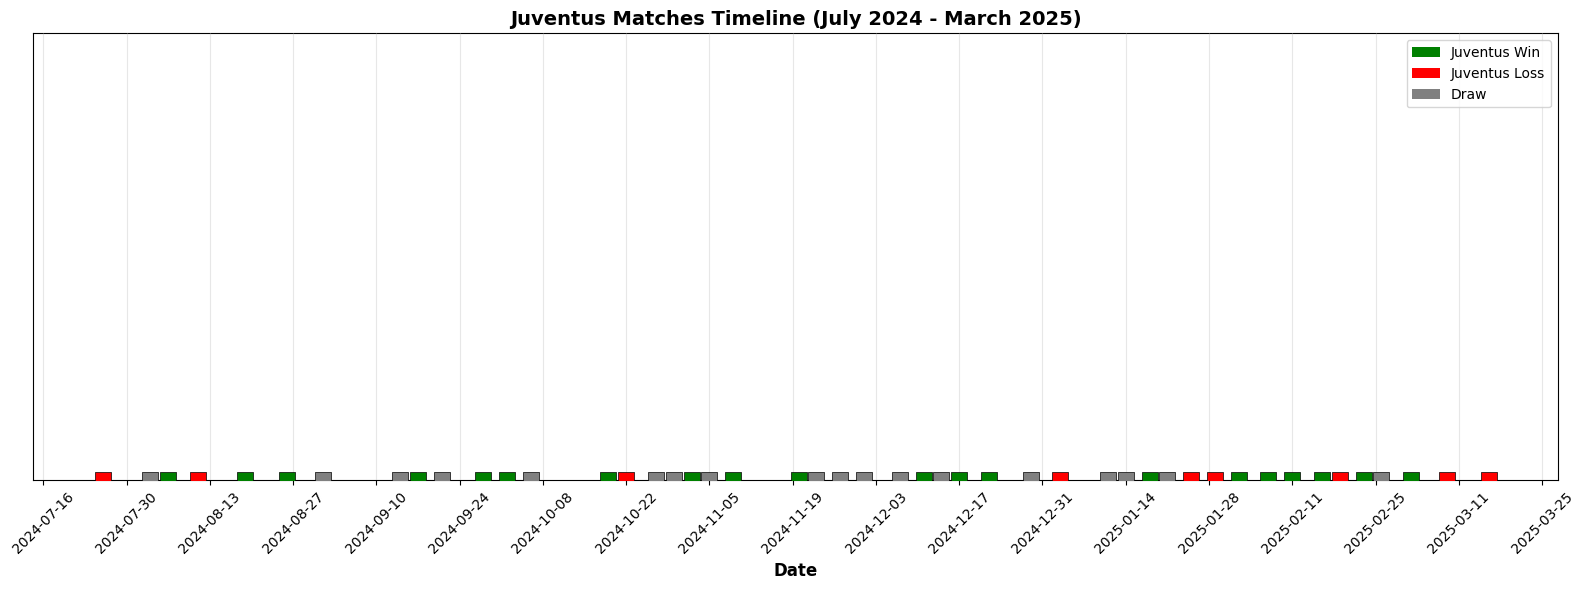

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

df_matches = pd.DataFrame(matches)

df_matches['date_obj'] = pd.to_datetime(df_matches['data'])

df_matches = df_matches.sort_values('date_obj')


def get_match_color(partita, risultato):
    
    scores = risultato.split('-')
    try:
        score1 = int(scores[0])
        score2 = int(scores[1])
    except ValueError:
        return 'gray'
    
    if 'Juventus' in partita.split('-')[0]:
        juventus_score = score1
        opponent_score = score2
    else:
        juventus_score = score2
        opponent_score = score1
    
    if juventus_score > opponent_score:
        return 'green'
    elif juventus_score < opponent_score:
        return 'red'
    else:
        return 'gray'

df_matches['color'] = df_matches.apply(lambda row: get_match_color(row['partita'], row['risultato']), axis=1)

fig, ax = plt.subplots(figsize=(16, 6))

y_position = 0
for i, row in df_matches.iterrows():
    ax.scatter(row['date_obj'], y_position, s=120, alpha=1, color=row['color'], edgecolors='black', linewidth=0.5, zorder=100,marker='s')

ax.set_ylim(0, 0.3)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_title('Juventus Matches Timeline (July 2024 - March 2025)', fontsize=14, fontweight='bold')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))  # Show every 2 weeks
plt.xticks(rotation=45)

ax.set_yticks([])
ax.set_ylabel('')
for spine in ax.spines.values():
    spine.set_zorder(0.5)
ax.grid(True, axis='x', alpha=0.3, zorder=2)


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Juventus Win'),
                   Patch(facecolor='red', label='Juventus Loss'),
                   Patch(facecolor='gray', label='Draw')]
ax.legend(handles=legend_elements, loc='upper right')


plt.tight_layout()


wins = len(df_matches[df_matches['color'] == 'green'])
losses = len(df_matches[df_matches['color'] == 'red'])
draws = len(df_matches[df_matches['color'] == 'gray'])

print(f"Total matches: {len(df_matches)}")
print(f"Wins: {wins} | Losses: {losses} | Draws: {draws}")
print(f"Win rate: {wins/len(df_matches)*100:.1f}%")
print(f"Date range: {df_matches['data'].min()} to {df_matches['data'].max()}")
print(f"Time span: {(df_matches['date_obj'].max() - df_matches['date_obj'].min()).days} days")

plt.show()

In [ ]:
#simulate sentiiment analysis per day
def simulate_sentiment_analysis_per_day(comments, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date)
    sentiment_scores = {date: 0 for date in date_range}
    
    for comment in comments:
        comment_date = comment.date.date()
        if start_date <= comment_date <= end_date:
            sentiment_scores[comment_date] += comment.likes  # Using likes as a proxy for sentiment
    
    return sentiment_scores